<a href="https://colab.research.google.com/github/Wangadeveloper/huduma-online-cyber/blob/main/enefit_data_set_for_making_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
'''importing our trainig data'''
train = pd.read_csv('train.csv')
train.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113005 entries, 0 to 113004
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   county              113005 non-null  int64  
 1   is_business         113005 non-null  int64  
 2   product_type        113005 non-null  int64  
 3   target              113005 non-null  float64
 4   is_consumption      113005 non-null  int64  
 5   datetime            113005 non-null  object 
 6   data_block_id       113005 non-null  int64  
 7   row_id              113005 non-null  int64  
 8   prediction_unit_id  113005 non-null  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 7.8+ MB


In [4]:
#convert datetime column to date format
train['datetime']=pd.to_datetime(train['datetime'])

In [5]:
# check datatypes
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113005 entries, 0 to 113004
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   county              113005 non-null  int64         
 1   is_business         113005 non-null  int64         
 2   product_type        113005 non-null  int64         
 3   target              113005 non-null  float64       
 4   is_consumption      113005 non-null  int64         
 5   datetime            113005 non-null  datetime64[ns]
 6   data_block_id       113005 non-null  int64         
 7   row_id              113005 non-null  int64         
 8   prediction_unit_id  113005 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(7)
memory usage: 7.8 MB


In [6]:
train.isna().sum()

county                0
is_business           0
product_type          0
target                0
is_consumption        0
datetime              0
data_block_id         0
row_id                0
prediction_unit_id    0
dtype: int64

In [7]:
train.shape[0]

113005

In [8]:
train = train.dropna(how='any')
train.shape[0]

113005

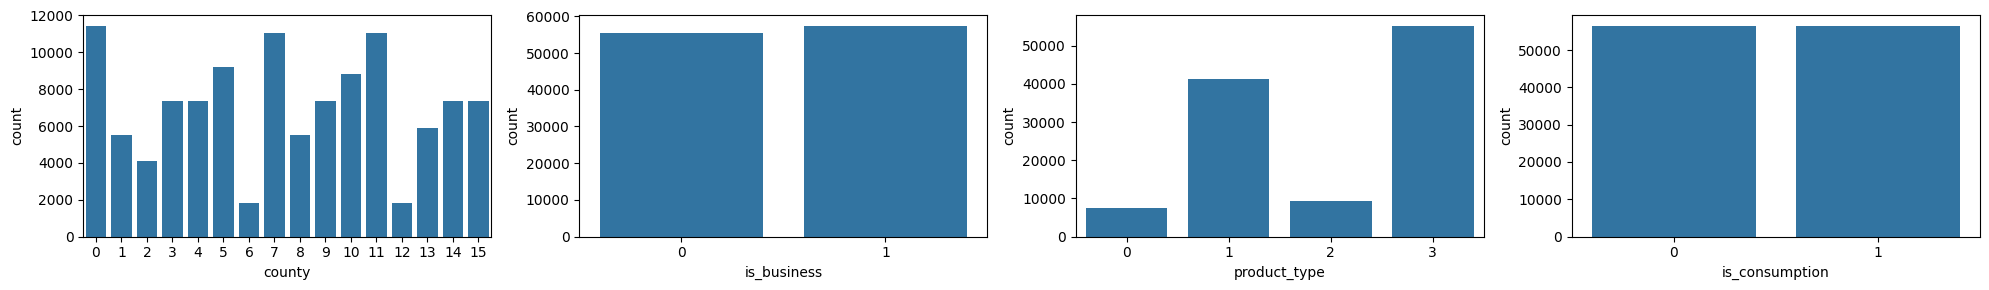

In [10]:
categorical_column = ['county','is_business','product_type','is_consumption']

fig, axs = plt.subplots(1, len(categorical_column), figsize=(5*len(categorical_column ), 3))

for i, column in enumerate(categorical_column ):
    train[column]=train[column].astype('category')
    _ = sns.countplot(train, x=column, ax=axs[i])

_ = fig.tight_layout()

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113005 entries, 0 to 113004
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   county              113005 non-null  category      
 1   is_business         113005 non-null  category      
 2   product_type        113005 non-null  category      
 3   target              113005 non-null  float64       
 4   is_consumption      113005 non-null  category      
 5   datetime            113005 non-null  datetime64[ns]
 6   data_block_id       113005 non-null  int64         
 7   row_id              113005 non-null  int64         
 8   prediction_unit_id  113005 non-null  int64         
dtypes: category(4), datetime64[ns](1), float64(1), int64(3)
memory usage: 4.7 MB


we can plot the average production and consumption timeseries,to see the cyclical patterns in production and consumption rates across diffrent perids

In [12]:
train_avgd = (
    train.groupby(['datetime','is_consumption'])['target'].mean().unstack()
    .rename({0: 'produced', 1:'consumed'}, axis=1)
)
train_avgd

is_consumption,produced,consumed
datetime,,
2021-09-01 00:00:00,0.071508,325.570623
2021-09-01 01:00:00,0.194295,315.820951
2021-09-01 02:00:00,0.030246,315.752328
2021-09-01 03:00:00,0.024869,311.909574
2021-09-01 04:00:00,0.040852,317.493836
...,...,...
2021-10-09 03:00:00,0.804873,294.769667
2021-10-09 04:00:00,0.903365,301.112302
2021-10-09 05:00:00,0.798762,301.339492


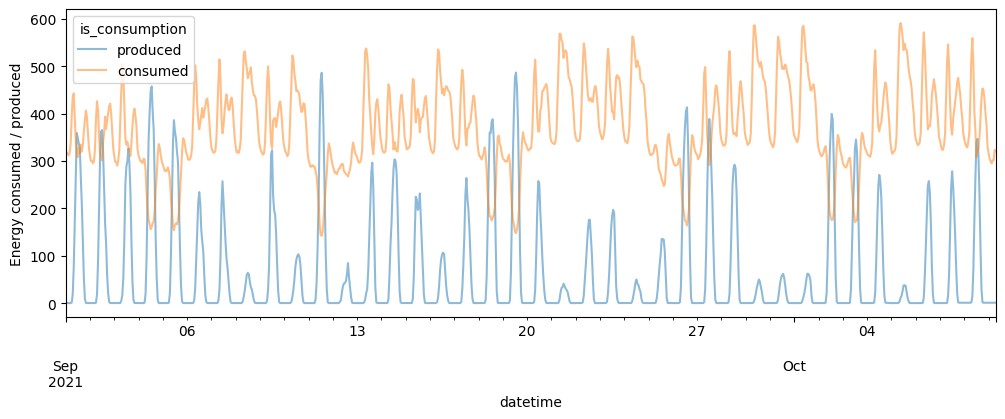

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
_ = train_avgd.plot(ax=ax, alpha=0.5)
_ = ax.set_ylabel('Energy consumed / produced')

Here are the montly averages for the same series
1. The consumptions peaks in either January or February and is the least in the summer months
2. The reverse is true for the production series

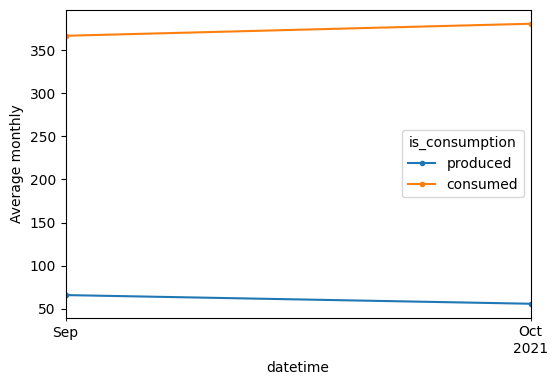

In [14]:
# plot of average weekly sales
fig,ax = plt.subplots(1,1,figsize=(6,4))
_ = train_avgd.resample('M').mean().plot(ax=ax, marker='.')
_ = ax.set_ylabel('Average monthly')

What about the patterns each hour? There seems to be a pattern for the produced series.

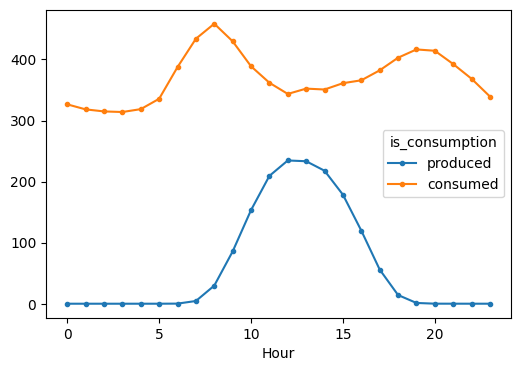

In [15]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
train_avgd.groupby(train_avgd.index.hour).mean().plot(ax=ax, marker='.')
_ = ax.set_xlabel('Hour')

## DateTime attributes

1. date
2. time: time in HH:MM:SS format
3. year
4. datediff_in_days: # days since the first observation in the training data
5. hour
6. dayofweek
7. week
8. month

For the last 4 features, we include sin and cosine transform to capture cyclical continuity.

In [16]:
earliest_time = train['datetime'].min()
def extract_dt_attributes(df:pd.DataFrame):
    # convert datetime column, if not done already
    df['datetime'] = pd.to_datetime(df['datetime'])

    # dates and times
    df['date'] = df['datetime'].dt.date
    df['time'] = df['datetime'].dt.strftime('%H:%M:%S')

    #
    df['year'] = df['datetime'].dt.year
    df['datediff_in_days'] = (
        df['datetime']- earliest_time
    ).dt.days

    # dictionary with time features as keys
    # and min and max as values
    time_features = {
        'hour': [0, 23],
        'dayofweek': [0, 6],
        'week': [1, 52],
        'month': [1, 12]
    }

    for col in time_features:
        if col=='week':
            df[col] = df['datetime'].dt.isocalendar().week.astype(np.int32)
        else:
            df[col] = getattr(df['datetime'].dt,col)


        ## sin and cosine features to capture the circular continuity
        col_min,col_max = time_features[col]
        angles = 2*np.pi*(df[col]-col_min)/(col_max-col_min+1)

        # add sin and cos
        df[col+'_sine'] = np.sin(angles).astype('float')
        df[col+'_cosine'] = np.cos(angles).astype('float')

In [17]:
%%time
# get train attributes
extract_dt_attributes(train)

CPU times: user 658 ms, sys: 9.02 ms, total: 667 ms
Wall time: 678 ms


## Lagged targets

For the test data, we are given the targets 2 days prior. To use this information, we will create a feature for lagged targets 2 days prior.

In [18]:
%%time
shift = 2
train['data_block_id_shifted'] = train['data_block_id'] + shift

train = pd.merge(train,(train[['county', 'is_business','is_consumption',
                               'product_type','data_block_id_shifted',
                               'time', 'target']].rename(columns={'data_block_id_shifted':'data_block_id',
            'target':f'target_{shift}days_ago'})),
    on = ['county', 'is_business','is_consumption',
          'product_type', 'data_block_id', 'time'],how='left')

# drop the redundant column
del train['data_block_id_shifted']

train.head(2)

CPU times: user 87.8 ms, sys: 19 ms, total: 107 ms
Wall time: 107 ms


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,...,dayofweek,dayofweek_sine,dayofweek_cosine,week,week_sine,week_cosine,month,month_sine,month_cosine,target_2days_ago
0,0,0,1,0.713,0,2021-09-01,0,0,0,2021-09-01,...,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN
1,0,0,1,96.590,1,2021-09-01,0,1,0,2021-09-01,...,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN


Clearly the target is very correlated with its lagged version. The degree of correlation is somewhat different across production and consumption patterns - the correlation is larger in the case of the consumption series.

In [19]:
# correlation between target and target_2_days_ago
(
    train[['is_consumption', 'target', 'target_2days_ago']].groupby('is_consumption')
    .corr().round(3)
)

target  target_2days_ago
is_consumption                                           
0              target             1.000             0.601
               target_2days_ago   0.601             1.000
1              target             1.000             0.931
               target_2days_ago   0.931             1.000

## Additional information

We will be looking at additional data in the following cells.

### Forecasted Electricity prices

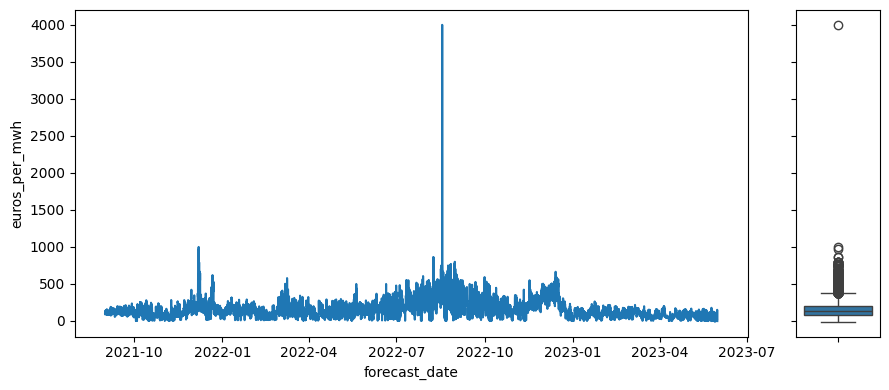

In [20]:
electricity_prices = pd.read_csv('electricity_prices.csv')
electricity_prices['forecast_date'] = pd.to_datetime(electricity_prices['forecast_date'])
electricity_prices['time'] = electricity_prices['forecast_date'].dt.strftime('%H:%M:%S')

fig, axs = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={'width_ratios': [8, 1]}, sharey=True)
_ = sns.lineplot(electricity_prices, x='forecast_date', y='euros_per_mwh', ax=axs[0])
_ = sns.boxplot(electricity_prices, y='euros_per_mwh', ax=axs[1])
#_ = axs[1].get_yaxis().set_visible(False)
fig.tight_layout()

Here is the corresponding plot for the forecast for electricity prices averaged by day.

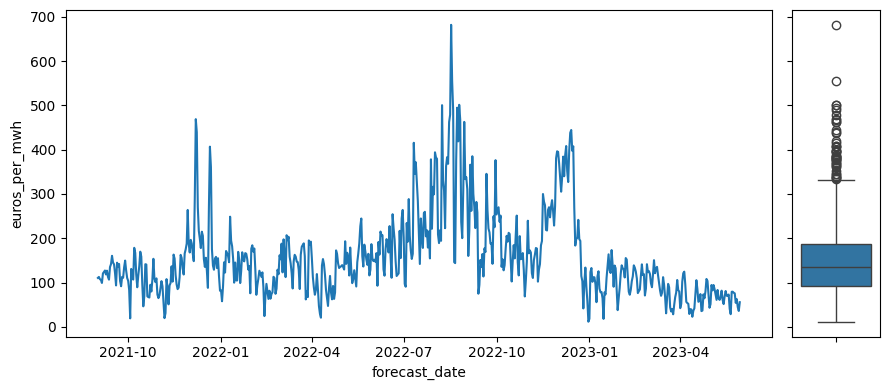

In [21]:
daily_elec_prices = (
    electricity_prices[['forecast_date', 'euros_per_mwh']].set_index('forecast_date')
    .resample('D').mean())

fig, axs = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={'width_ratios': [8, 1]}, sharey=True)
_ = sns.lineplot(daily_elec_prices, x='forecast_date', y='euros_per_mwh', ax=axs[0])
_ = sns.boxplot(daily_elec_prices, y='euros_per_mwh', ax=axs[1])
#_ = axs[1].get_yaxis().set_visible(False)
fig.tight_layout()

In [22]:
%%time
# merge features
train = pd.merge(train,electricity_prices[['time', 'data_block_id', 'euros_per_mwh']],
    how = 'left',on = ['time', 'data_block_id'])

train.head()

CPU times: user 56.1 ms, sys: 10.5 ms, total: 66.5 ms
Wall time: 134 ms


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,...,dayofweek_sine,dayofweek_cosine,week,week_sine,week_cosine,month,month_sine,month_cosine,target_2days_ago,euros_per_mwh
0,0,0,1,0.713,0,2021-09-01,0,0,0,2021-09-01,...,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN
1,0,0,1,96.590,1,2021-09-01,0,1,0,2021-09-01,...,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN
2,0,0,2,0.000,0,2021-09-01,0,2,1,2021-09-01,...,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN
3,0,0,2,17.314,1,2021-09-01,0,3,1,2021-09-01,...,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN
4,0,0,3,2.904,0,2021-09-01,0,4,2,2021-09-01,...,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN


### Gas prices

Unlike the electricity price forecasts, these are daily forecasts and not hourly forecasts.

In [23]:
gas_prices =  pd.read_csv('gas_prices.csv')
gas_prices['forecast_date'] = pd.to_datetime(gas_prices['forecast_date'])

gas_prices.head()

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1
1,2021-09-02,45.62,46.29,2021-09-01,2
2,2021-09-03,45.85,46.40,2021-09-02,3
3,2021-09-04,46.30,46.80,2021-09-03,4
4,2021-09-05,46.30,46.58,2021-09-04,5


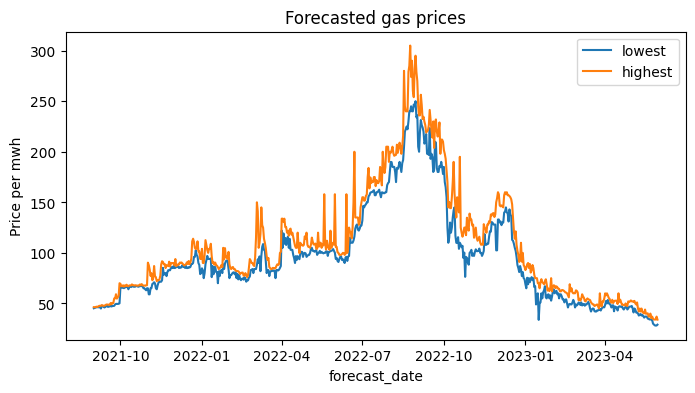

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
_ = sns.lineplot(gas_prices, x='forecast_date', y='lowest_price_per_mwh', ax=ax, label='lowest')
_ = sns.lineplot(gas_prices, x='forecast_date', y='highest_price_per_mwh', ax=ax, label='highest')
_ = ax.legend()
_ = ax.set_ylabel('Price per mwh')
_ = ax.set_title('Forecasted gas prices')

In [25]:
# merge features
train = pd.merge(
    train,
    gas_prices[['data_block_id', 'lowest_price_per_mwh', 'highest_price_per_mwh']],
    how = 'left',
    on = ['data_block_id']
)

train.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,...,week,week_sine,week_cosine,month,month_sine,month_cosine,target_2days_ago,euros_per_mwh,lowest_price_per_mwh,highest_price_per_mwh
0,0,0,1,0.713,0,2021-09-01,0,0,0,2021-09-01,...,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN
1,0,0,1,96.590,1,2021-09-01,0,1,0,2021-09-01,...,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN
2,0,0,2,0.000,0,2021-09-01,0,2,1,2021-09-01,...,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN
3,0,0,2,17.314,1,2021-09-01,0,3,1,2021-09-01,...,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN
4,0,0,3,2.904,0,2021-09-01,0,4,2,2021-09-01,...,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN


### Client information

In [26]:
client = pd.read_csv('client.csv')
# merge features
train = pd.merge(
    train,
    client.drop('date', axis=1),
    on = ['data_block_id', 'product_type', 'county', 'is_business'],
    how='left'
)
train.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,...,week_cosine,month,month_sine,month_cosine,target_2days_ago,euros_per_mwh,lowest_price_per_mwh,highest_price_per_mwh,eic_count,installed_capacity
0,0,0,1,0.713,0,2021-09-01,0,0,0,2021-09-01,...,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,1,96.590,1,2021-09-01,0,1,0,2021-09-01,...,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,2,0.000,0,2021-09-01,0,2,1,2021-09-01,...,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,2,17.314,1,2021-09-01,0,3,1,2021-09-01,...,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,3,2.904,0,2021-09-01,0,4,2,2021-09-01,...,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113005 entries, 0 to 113004
Data columns (total 31 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   county                 113005 non-null  int64         
 1   is_business            113005 non-null  int64         
 2   product_type           113005 non-null  int64         
 3   target                 113005 non-null  float64       
 4   is_consumption         113005 non-null  category      
 5   datetime               113005 non-null  datetime64[ns]
 6   data_block_id          113005 non-null  int64         
 7   row_id                 113005 non-null  int64         
 8   prediction_unit_id     113005 non-null  int64         
 9   date                   113005 non-null  object        
 10  time                   113005 non-null  object        
 11  year                   113005 non-null  int64         
 12  datediff_in_days       113005 non-null  int6

In [ ]:
for i, column in enumerate(categorical_column):
    train[column]=train[column].astype('category')

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113005 entries, 0 to 113004
Data columns (total 31 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   county                 113005 non-null  int64         
 1   is_business            113005 non-null  int64         
 2   product_type           113005 non-null  int64         
 3   target                 113005 non-null  float64       
 4   is_consumption         113005 non-null  category      
 5   datetime               113005 non-null  datetime64[ns]
 6   data_block_id          113005 non-null  int64         
 7   row_id                 113005 non-null  int64         
 8   prediction_unit_id     113005 non-null  int64         
 9   date                   113005 non-null  object        
 10  time                   113005 non-null  object        
 11  year                   113005 non-null  int64         
 12  datediff_in_days       113005 non-null  int6

In [29]:
train.isna().sum()

county                      0
is_business                 0
product_type                0
target                      0
is_consumption              0
datetime                    0
data_block_id               0
row_id                      0
prediction_unit_id          0
date                        0
time                        0
year                        0
datediff_in_days            0
hour                        0
hour_sine                   0
hour_cosine                 0
dayofweek                   0
dayofweek_sine              0
dayofweek_cosine            0
week                        0
week_sine                   0
week_cosine                 0
month                       0
month_sine                  0
month_cosine                0
target_2days_ago         6144
euros_per_mwh            2928
lowest_price_per_mwh     2928
highest_price_per_mwh    2928
eic_count                6144
installed_capacity       6144
dtype: int64

In [30]:
train = train.dropna(how='any')

In [31]:
train.shape

(106861, 31)

In [32]:
not_feature_columns = [
    'datetime',
    'row_id',
    'prediction_unit_id',
    'date',
    'time'
]

In [33]:
X = train.drop(['target', 'data_block_id'] + not_feature_columns, axis=1)
y = train['target']

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=0)

In [35]:
linear_reg = LinearRegression()
svr_reg = SVR(kernel='sigmoid') # You can choose different kernels if needed
xgb_reg = XGBRegressor(random_state=42)
rf_reg = RandomForestRegressor(random_state=42)

In [37]:
scores = cross_val_score(linear_reg,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

CV accuracy: 0.852 +/- 0.011


In [ ]:
scores = cross_val_score(svr_reg,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

In [ ]:
scores = cross_val_score(xgb_reg,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

In [36]:
voting_reg = VotingRegressor(estimators=[('linear', linear_reg),
                                         ('svr', svr_reg), ('xgb', xgb_reg),
                                         ('rf', rf_reg)], n_jobs=5)

In [ ]:
scores = cross_val_score(voting_reg,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

In [ ]:
voting_reg.fit(X_train, y_train)

In [ ]:
# Make predictions on the testing data
pred = voting_reg.predict(X_test) # Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, pred) # Calculate R-squared (R2) score
r2 = r2_score(y_test, pred) # Print the evaluation metrics

In [ ]:
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'R-squared (R2) Score: {r2:.2f}')